In [21]:
from HKZ_model import DESModel
from openclsim.plot import get_log_dataframe
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [3]:
m = DESModel()
m.define_sites()
m.define_equipment()
m.resources(kind="allowable_sea_state")
m.processes()
m.start_simulation()

m1 = DESModel()
m1.define_sites()
m1.define_equipment()
m1.resources(kind="response_motions")
m1.processes()
m1.start_simulation()

In [4]:
dates = pd.date_range(start=dt.datetime(1990, 1, 1), end=dt.datetime(2019, 1, 1), freq="H")
indices = np.random.randint(0, len(dates), size=10_000)
start_dates = dates[indices] 

In [5]:
results = dict(
    StartDate=start_dates, 
    ProjectDurationRAO=[], 
    DowntimeDurationRAO = [],
    ProjectDurationSea=[],
    DowntimeDurationSea = []
)

for date in tqdm(start_dates):
    m.restart_simulation(start_date=date)
    results["ProjectDurationSea"].append(m.project_length())
    results["DowntimeDurationSea"].append(m.get_downtime())

    m1.restart_simulation(start_date=date)
    results["ProjectDurationRAO"].append(m1.project_length())
    results["DowntimeDurationRAO"].append(m1.get_downtime())

In [6]:
df = pd.DataFrame(results)
df["WorkabilityRAO"] = 1 - (df["DowntimeDurationRAO"] / df["ProjectDurationRAO"])
df["ProjectDurationRAO"] = df["ProjectDurationRAO"].dt.total_seconds() / (3600 * 24)

df["WorkabilitySea"] = 1 - (df["DowntimeDurationSea"] / df["ProjectDurationSea"])
df["ProjectDurationSea"] = df["ProjectDurationSea"].dt.total_seconds() / (3600 * 24)
df["Month"] = df["StartDate"].dt.month

Text(0.5, 0, '')

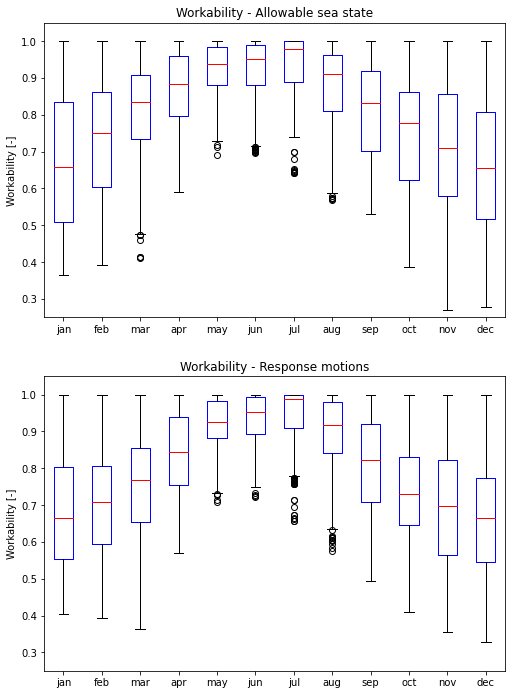

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

df.boxplot(
    column="WorkabilitySea",
    by="Month",
    ax=ax[0],
    grid=False,
    color="blue",
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
)

df.boxplot(
    column="WorkabilityRAO",
    by="Month",
    ax=ax[1],
    grid=False,
    color="blue",
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
)

fig.suptitle("")
ax[0].set_title("Workability - Allowable sea state")
ax[1].set_title("Workability - Response motions")

ax[0].set_ylabel("Workability [-]")
ax[1].set_ylabel("Workability [-]")

ax[0].set_ylim(0.25, 1.05)
ax[1].set_ylim(0.25, 1.05)

ax[0].set_xticks([i for i in range(1, 13)])
ax[0].set_xticklabels(["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"])
ax[0].set_xlabel("")

ax[1].set_xticks([i for i in range(1, 13)])
ax[1].set_xticklabels(["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"])
ax[1].set_xlabel("")

# plt.savefig("./data/results/workability_boxplots_optimised.jpg", dpi=100, bbox_inches="tight")

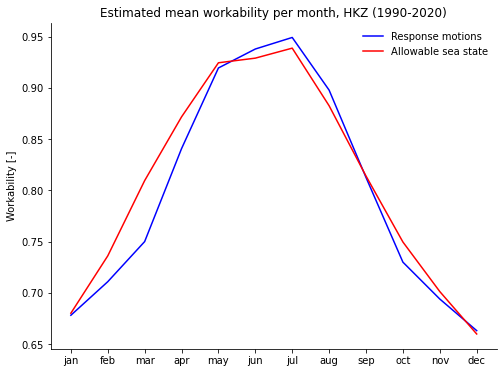

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

ax.plot(
    df.groupby("Month")["WorkabilityRAO"].mean(),
    color="blue",
    label="Response motions"
)

ax.plot(
    df.groupby("Month")["WorkabilitySea"].mean(),
    color="red",
    label="Allowable sea state"
)

ax.set_xticks([i for i in range(1, 13)])
ax.set_xticklabels(["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"])
ax.set_xlabel("")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Workability [-]")

ax.set_title("Estimated mean workability per month, HKZ (1990-2020)")

ax.legend(frameon=False)

# plt.savefig("./data/results/mean_workability_optimised.jpg", dpi=100, bbox_inches="tight")

In [23]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
        y=df.groupby("Month")["WorkabilityRAO"].mean(),
        name="Response motions",
        line=dict(color="#253a79")
    )
)

fig.add_trace(
    go.Scatter(
        x=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
        y=df.groupby("Month")["WorkabilitySea"].mean(),
        name="Allowable sea state",
        line=dict(color="#ff8702")
    )
)

fig.update_layout(
    width=700,
    height=400,
    title="Estimated mean workability per month, HKZ (1990-2020)",
    yaxis=dict(title="Workability [-]"),
    margin=dict(
        t=40,
        b=30,
        r=10,
        l=10
    )
)

In [15]:
windows = m1.weather_resource.activity_database["Launch Deep Dig-It"]["windows"]
windows["month"] = windows["start_date"].dt.month
windows["length"] = windows["length"].dt.total_seconds() / (3600 * 24)
daa = windows[~windows["violated"]]

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))


daa.boxplot(
    column="length",
    by="month",
    ax=ax,
    grid=False,
    color="blue",
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
)

fig.suptitle("")
ax.set_title("Availability of workable weather windows - Response motions")

ax.set_ylabel("Persistency [days]")

ax.set_ylim(0, 30)

ax.set_xticks([i for i in range(1, 13)])
ax.set_xticklabels(["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"])
ax.set_xlabel("")


In [17]:
windows = m.weather_resource.activity_database["Launch Deep Dig-It"]["windows"]
windows["month"] = windows["start_date"].dt.month
windows["length"] = windows["length"].dt.total_seconds() / (3600 * 24)
daa = windows[~windows["violated"]]

AttributeError: Can only use .dt accessor with datetimelike values

Text(0.5, 0, '')

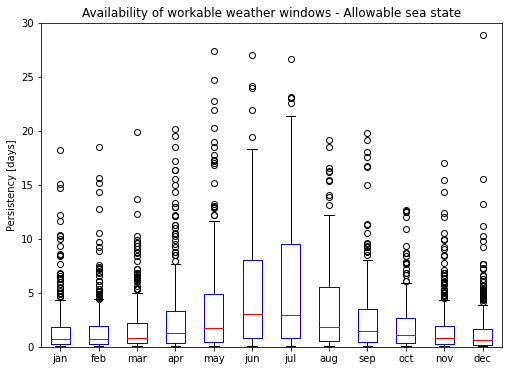

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))


daa.boxplot(
    column="length",
    by="month",
    ax=ax,
    grid=False,
    color="blue",
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
)

fig.suptitle("")
ax.set_title("Availability of workable weather windows - Allowable sea state")

ax.set_ylabel("Persistency [days]")

ax.set_ylim(0, 30)

ax.set_xticks([i for i in range(1, 13)])
ax.set_xticklabels(["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"])
ax.set_xlabel("")